In [1]:
import re
import nltk
import os
import time
import spacy


from nltk.corpus import words as english_words, stopwords
from nltk.stem import PorterStemmer # suffixes (“ing”, “ly”, “es”, “s” etc) from a word
from nltk.stem import WordNetLemmatizer # Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.metrics.association import BigramAssocMeasures, TrigramAssocMeasures
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder 
from collections import Counter 
from wordcloud import WordCloud # Make a word cloud with a single word that’s repeated


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')


In [2]:
files = []
for dirname, _, filenames in os.walk('speeches'):
    for filename in filenames:
        with open((os.path.join(dirname, filename)),encoding='utf-8') as w: files.append(w.read())

In [3]:
names=[ x.replace('.txt','') for x in filenames]

In [4]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
city, date, month=[],[],[]
for n in names:
    index=-1
    for m in months:
        index=n.find(m)
        if index!=-1:
            month.append(m)
            break
    city.append(n[:index])
    date.append(n[index+3:])

In [5]:
# parsing date
day,year=[],[]
day=[x.split("_")[0] for x in date]
year=[x.split("_")[1] for x in date]
date=[x+y+z for x,y,z in zip(day, month, year)]
new_date=pd.to_datetime(date)

In [6]:
cities=[re.sub('([A-Z])',r' \1', c ) for c in city]

In [7]:
data=pd.DataFrame(data={'City':cities,'Date':new_date, 'Speech':files})

In [8]:
data.head()

,City,Date,Speech
0,Battle Creek,2019-12-19,﻿Thank you. Thank you. Thank you to Vice Presi...
1,Bemidji,2020-09-18,There's a lot of people. That's great. Thank y...
2,Charleston,2020-02-28,Thank you. Thank you. Thank you. All I can say...
3,Charlotte,2020-03-02,"I want to thank you very much. North Carolina,..."
4,Cincinnati,2019-08-01,Thank you all. Thank you very much. Thank you ...


In [9]:
def speech_to_words (speech, remove_stopwords=False):
    cln_speech=re.sub('[^a-zA-Z]'," ", speech) # remove non-letters 
    words=cln_speech.lower().split()       # convert to small letters and split to words 
    if remove_stopwords:                       # remove stop words
        stop=stopwords.words('english')
        stop.extend(['from', 'subject', 're', 'edu', 'use', 'going', 'said', 'you','and'])
        stop=(stop)
        words=[w for w in words if not w in stop]
    stemmer=nltk.PorterStemmer()               # remove suffixes (“ing”, “ly”, “es”, “s” etc)
    clean_words=[stemmer.stem(w) for w in words]
    lemmatizer= WordNetLemmatizer()            # procedure of obtaining the root form of the word
    simple_words=[lemmatizer.lemmatize(w, pos='a') for w in clean_words]
    return simple_words

In [10]:
def speech_to_words2 (speech, remove_stopwords=False): # without stemmer &  lematizer
    cln_speech=re.sub('[^a-zA-Z]'," ", speech) # remove non-letters 
    words=cln_speech.lower().split()       # convert to small letters and split to words 
    if remove_stopwords:                       # remove stop words
        stop=stopwords.words('english')
        stop.extend(['from', 'subject', 're', 'edu', 'use', 'going', 'said', 'you','and', 'wow'])
        stop=(stop)
        words=[w for w in words if not w in stop]
    return words

In [11]:
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
def speech_to_sentences (speech, tokenizer, remove_stopwords=False):
    raw_sentences=tokenizer.tokenize(speech)  # Use the NLTK tokenizer to split the paragraph into sentences
    sentences=[]
    for sentence in raw_sentences:
        if len(sentence)>0:
            sentences.append(speech_to_words2(sentence, remove_stopwords))
    return sentences

In [13]:
speech_words=data['Speech'].apply(lambda speech:speech_to_words (speech, remove_stopwords=True))
data['words_in_speech']=data['Speech'].apply(lambda x: len(x.split(" ")))

speech_sentences=data['Speech'].apply(lambda speech: speech_to_sentences (speech,tokenizer, remove_stopwords=True))
for i in speech_sentences.index: # clear from empty lists
    speech_sentences[i]=[x for x in speech_sentences[i] if x!=[]]
data['sentences_in_speech']=speech_sentences.apply(lambda x: len(x))

In [14]:
print(f'In all speeches are: {data.words_in_speech.sum()} words and {data.sentences_in_speech.sum()} sentences.')

all_words=[]     # how many words in all speeches
for word in speech_words:
    all_words=all_words+word

In all speeches are: 370514 words and 36858 sentences.


# Most frequent words

In [15]:
word_freq = Counter(all_words) # lets try to count the top occuring terms in speeches

In [16]:
Biden=word_freq['biden']
print(f'Donald Trump mentioned Biden {Biden} times in his speeches.')

Donald Trump mentioned Biden 491 times in his speeches.


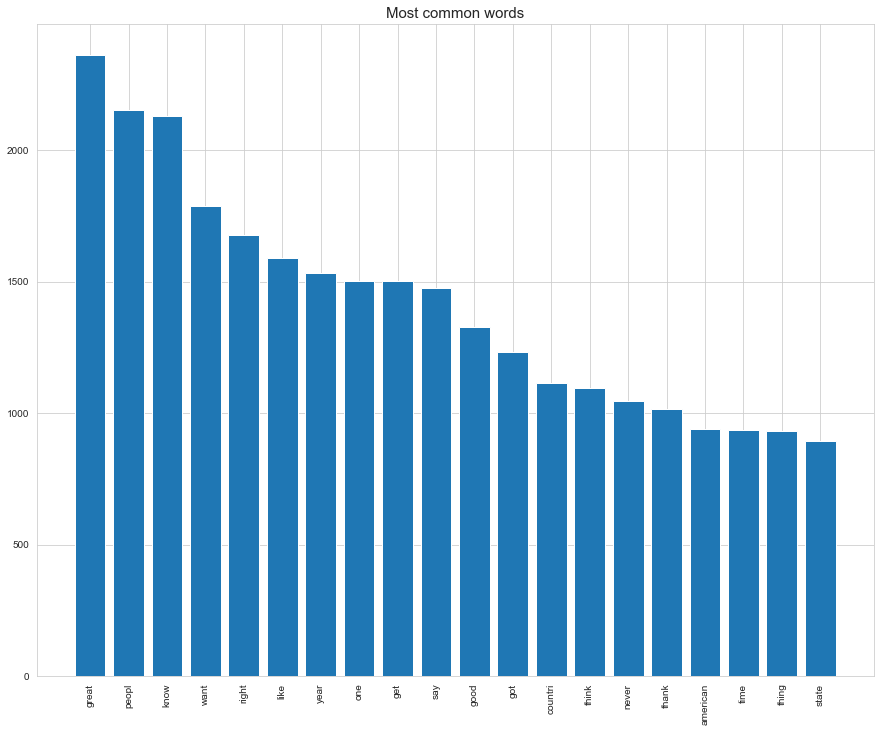

In [17]:
# lets try to vizualize the top occuring terms
words = [word[0] for word in word_freq.most_common(20)]   # top 20 most common words
count = [word[1] for word in word_freq.most_common(20)]  #how many time they use in speech

plt.figure(figsize=(15, 12))
plt.bar(words, count)
plt.xticks(words, rotation=90)
plt.title('Most common words', fontsize=15)
plt.show()

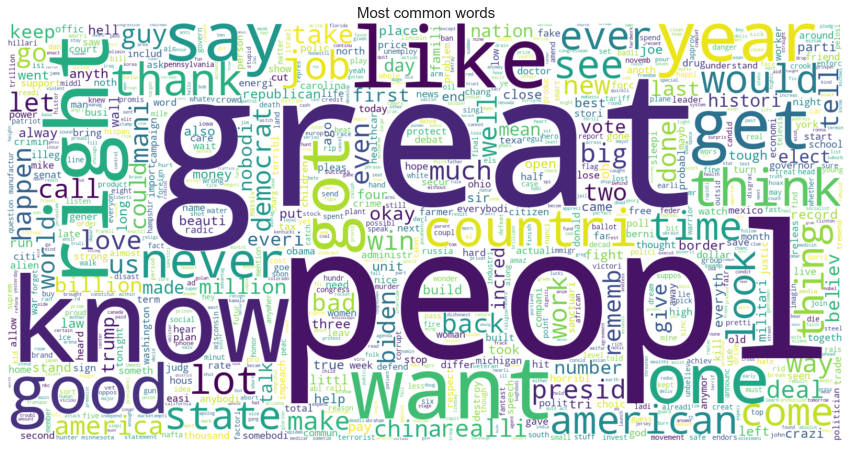

In [18]:
# Plotting wordCloud with most common words
wc = WordCloud(max_words = 1000, width = 1600, height = 800, background_color ='white',repeat=True)
wc.fit_words(word_freq)

plt.figure(figsize = (15, 15), facecolor = None)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words', fontsize=15)
plt.show()

In [19]:
text=" ".join(files)
cl_text=speech_to_words2(text, remove_stopwords=True)

bigram_measures = BigramAssocMeasures()
bi_finder = BigramCollocationFinder.from_words(cl_text)
bi_phrases=bi_finder.nbest(bigram_measures.raw_freq, 10)
bi_phrases=list((x+" "+y) for x,y in bi_phrases)
print(f'The most frequent 2 words phrases in Donald Trump rallies are: \n\n{bi_phrases} \n\n')

trigram_measures = TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(cl_text)
tri_phrases=tri_finder.nbest(trigram_measures.raw_freq, 10)
tri_phrases=list((x+" "+ y + " "+ z) for x, y, z, in  tri_phrases)
print(f'The most frequent 3 words phrases in Donald Trump rallies are: \n\n{tri_phrases} ')

The most frequent 2 words phrases in Donald Trump rallies are: 

['united states', 'make america', 'thank much', 'great job', 'fake news', 'joe biden', 'north carolina', 'four years', 'years ago', 'thank thank'] 


The most frequent 3 words phrases in Donald Trump rallies are: 

['make america great', 'late term abortion', 'four years ago', 'thank much thank', 'winning winning winning', 'new york times', 'president united states', 'keep bear arms', 'great american flag', 'one people one'] 


## Calculating the readability index

In [20]:
import textstat

# Returns the Flesch Reading Ease Score
data['reading_score']=data['Speech'].apply(lambda x: textstat.flesch_reading_ease(x))
print(f'Mean Flesch Reading Easy Score is : {data.reading_score.mean()}')

Mean Flesch Reading Easy Score is : 84.85228571428573


No handles with labels found to put in legend.


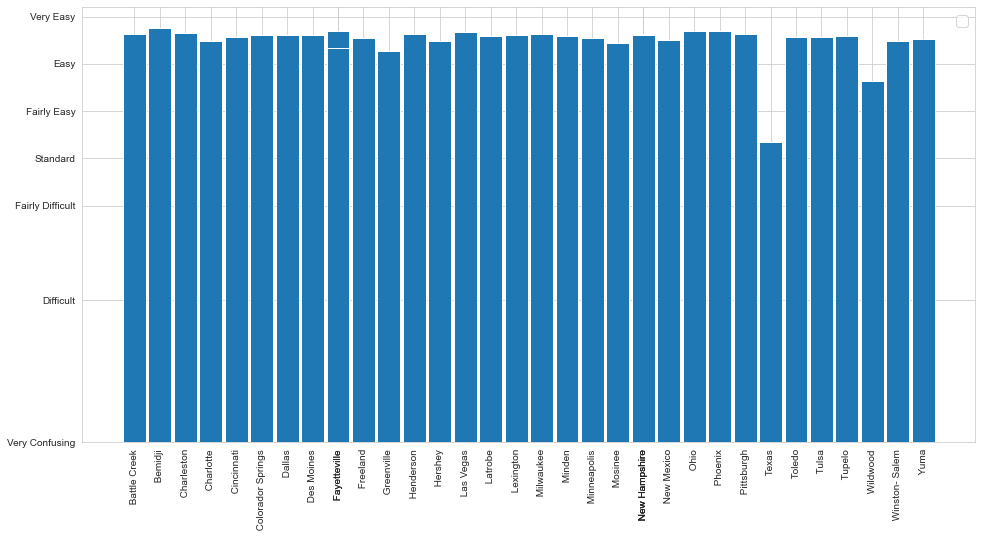

In [21]:
plt.figure(figsize=(16,8))
names = data['City'].values
dif=["Very Confusing", "Difficult", "Fairly Difficult", "Standard","Fairly Easy", "Easy", "Very Easy"]
grade= [0, 30,50, 60, 70, 80, 90]
barWidth = 0.9
plt.bar(names, data.reading_score,width=barWidth)
plt.xticks(names, rotation=90)
plt.yticks(grade, dif)
plt.legend(fontsize=15) 
plt.show()

### In general, Trump's speech is quite simple and understandable, because it is written for a wide range of people. But the analysis shows that in Texas the readability was more difficult compared to other cities.

# Sentiment analysis of Donald Trump

In [22]:
s_analyzer=SentimentIntensityAnalyzer()
sentiments=data['Speech'].apply(lambda x: s_analyzer.polarity_scores(x))
data['negative_sentiment']=sentiments.apply(lambda x : x['neg'])
data['neutral_sentiment']=sentiments.apply(lambda x : x['neu'])
data['positive_sentiment']=sentiments.apply(lambda x : x['pos'])

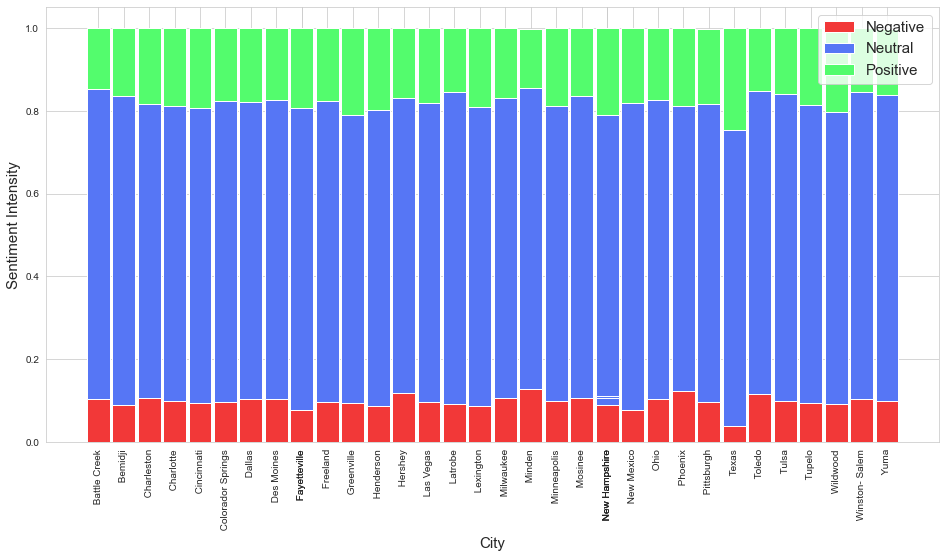

In [23]:
plt.figure(figsize=(16,8))
names = data['City'].values
barWidth = 0.9

# Create negative Bars
plt.bar( names, data.negative_sentiment, color='#f23838', \
        edgecolor='white', width=barWidth, label='Negative')
# Create neutral Bars
plt.bar( names,data.neutral_sentiment, bottom=data.negative_sentiment, color='#5676f5', 
        edgecolor='white', width=barWidth, label='Neutral')
# Create positive Bars
plt.bar( names,data.positive_sentiment, \
        bottom=[i+j for i,j in zip(data.negative_sentiment, data.neutral_sentiment)], \
        color='#53fc6d', edgecolor='white', width=barWidth, label='Positive')
 
plt.xticks(names, rotation=90)
plt.xlabel("City", fontsize=15)
plt.ylabel("Sentiment Intensity", fontsize=15)
plt.legend(fontsize=15) 
plt.show()



### After Sentiment analysis we also can see that emotionally more positive speech was in Texas

In [24]:
# find and create list of all negative words in speeches
negative_words=[]
for word in cl_text:
    if s_analyzer.polarity_scores(word)['compound']<0:
        negative_words.append(word)
        
neg_words=Counter(negative_words)

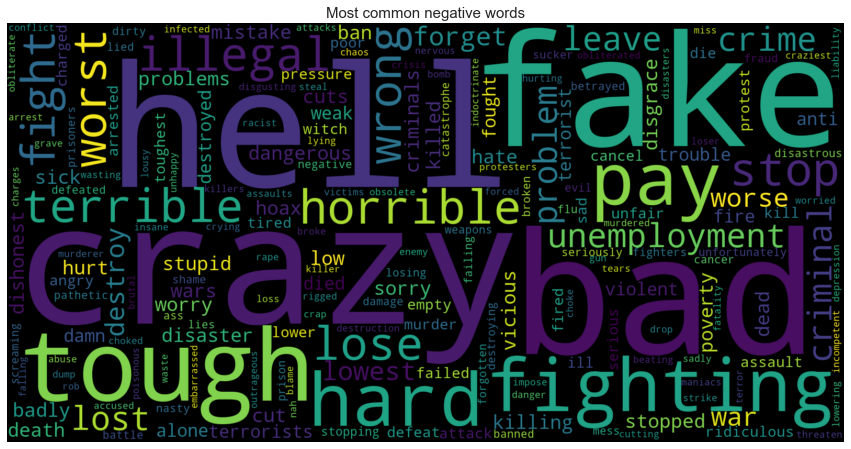

In [25]:
wc1 = WordCloud(max_words = 200, width = 1600, height = 800, background_color ='black',repeat=True)
wc1.fit_words(neg_words)

plt.figure(figsize = (15, 10), facecolor = None)
plt.axis("off")
plt.imshow(wc1, interpolation='bilinear')
plt.title('Most common negative words', fontsize=15)
plt.show()

In [26]:
# find and create list of all positive words in speeches
positive_words=[]
for word in cl_text:
    if s_analyzer.polarity_scores(word)['compound']>0:
        positive_words.append(word)
        
pos_words=Counter(positive_words)

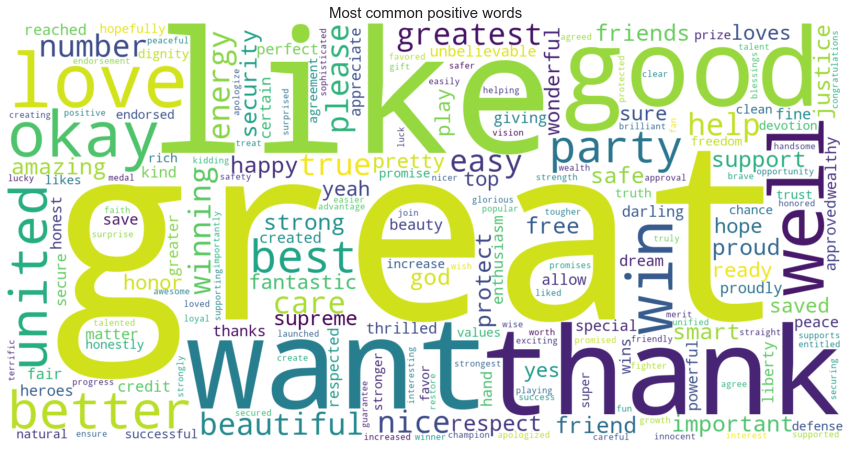

In [27]:
wc2 = WordCloud(max_words = 200, width = 1600, height = 800, background_color ='white',repeat=True)
wc2.fit_words(pos_words)

plt.figure(figsize = (15, 10), facecolor = None)
plt.axis("off")
plt.imshow(wc2, interpolation='bilinear')
plt.title('Most common positive words', fontsize=15)
plt.show()

# spaCy

### Named Entity Recognition

In [28]:
# spaCy uses a statistical model to classify a broad range of entities, 
# including persons, organisations, dates

nlp = spacy.load("en_core_web_sm")
doc = nlp(data['Speech'][0])
spacy.displacy.render(doc, style='ent',jupyter=True)

### POS tagging and Dependency Parsing

In [29]:
doc = nlp(data['Speech'][0]) # first speech sentence segmentation
sentence_l = [s for s in doc.sents]

# spaCy features a fast and accurate syntactic dependency parser, 
# and has a rich API for navigating the tree.
spacy.displacy.render(sentence_l[3], style='dep',jupyter=True,options = {'compact':60})
pos_list = [(token, token.pos_) for token in sentence_l[3]]